In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
!pip install lime
!pip install pytorch-gradcam -q
!pip install keras-grad-cam matplotlib

ERROR: Could not find a version that satisfies the requirement keras-grad-cam (from versions: none)
ERROR: No matching distribution found for keras-grad-cam


In [4]:
pip install pillow scikit-image lime shap opencv-python matplotlib tensorflow


Note: you may need to restart the kernel to use updated packages.


In [5]:
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import lime
from lime import lime_image
import shap
from tensorflow.keras.applications import VGG16  # Replace with your pre-trained model if not VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2  # Import cv2 for image processing
from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from skimage.transform import resize
from tensorflow.keras.models import Model

2025-04-21 19:36:18.460049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745264178.511795    2681 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745264178.525476    2681 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745264178.632083    2681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745264178.632205    2681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745264178.632208    2681 computation_placer.cc:177] computation placer alr

In [11]:
!pip install kagglehub
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 184.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 90.3 MB/s eta 0:00:00


In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

In [13]:

dataset_dir = path + "/TB_Chest_Radiography_Database"
normal_dir = os.path.join(dataset_dir, "Normal")
tuberculosis_dir = os.path.join(dataset_dir, "Tuberculosis")

In [14]:
def preprocess_images(image_dir, label, limit=1500):
    images = []
    labels = []

    all_filenames = [f for f in os.listdir(image_dir) if f.endswith(".png")]
    sampled_filenames = random.sample(all_filenames, min(limit, len(all_filenames)))

    for filename in sampled_filenames:
        image_path = os.path.join(image_dir, filename)
        try:
            image = Image.open(image_path)
            image = image.convert("RGB")
            image = image.resize((256, 256))
            image = np.array(image) / 255.0
            images.append(image)
            labels.append(label)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    return images, labels

In [15]:
import albumentations as A
from PIL import Image
import numpy as np
import os
import random
from tqdm import tqdm

# Define augmentation
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5)
])

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [17]:
# Load and preprocess normal images
normal_images, normal_labels = preprocess_images(normal_dir, label=0,limit = 1500)

In [18]:
# Load and preprocess tuberculosis images
tuberculosis_images, tuberculosis_labels = preprocess_images(tuberculosis_dir, label=1)

In [20]:
extra_needed = 1500 - len(tuberculosis_images)
augmented_images = []
augmented_labels = []

In [22]:
for i in tqdm(range(extra_needed)):
    img = random.choice(tuberculosis_images)
    img_aug = augment(image=(img * 255).astype(np.uint8))['image'] / 255.0
    augmented_images.append(img_aug)
    augmented_labels.append(1)

100%|██████████| 800/800 [00:00<00:00, 825.08it/s] 


In [23]:
tuberculosis_images += augmented_images
tuberculosis_labels += augmented_labels

In [24]:
# Combine normal and tuberculosis images
images = normal_images + tuberculosis_images
labels = normal_labels + tuberculosis_labels

In [25]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [26]:
from sklearn.model_selection import train_test_split

# First, split into train+val and test sets
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Then, split train+val into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.1, random_state=42, stratify=train_val_labels
)


In [27]:
# Check the shape of the training and testing sets
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)
print("Train labels shape:", val_labels.shape)
print("Test labels shape:", val_labels.shape)

Train images shape: (2160, 256, 256, 3)
Test images shape: (600, 256, 256, 3)
Train labels shape: (2160,)
Test labels shape: (600,)
Train labels shape: (240,)
Test labels shape: (240,)


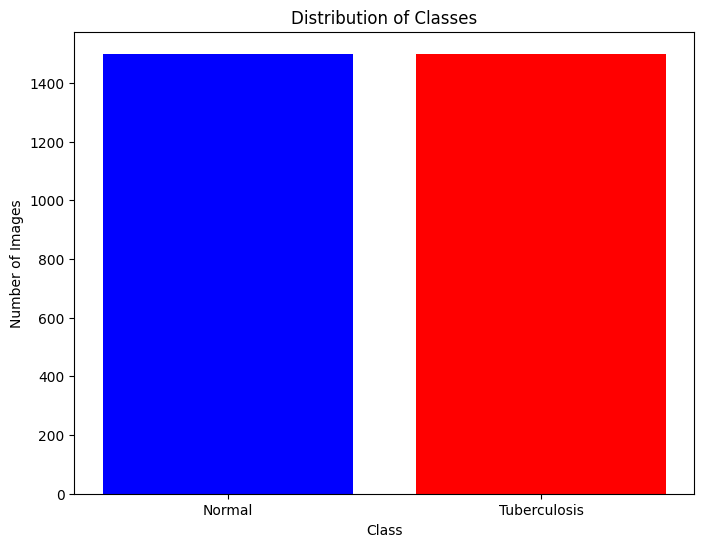

In [28]:
# Visualize the distribution of classes
plt.figure(figsize=(8, 6))
plt.bar(["Normal", "Tuberculosis"], [len(normal_images), len(tuberculosis_images)], color=['blue', 'red'])
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

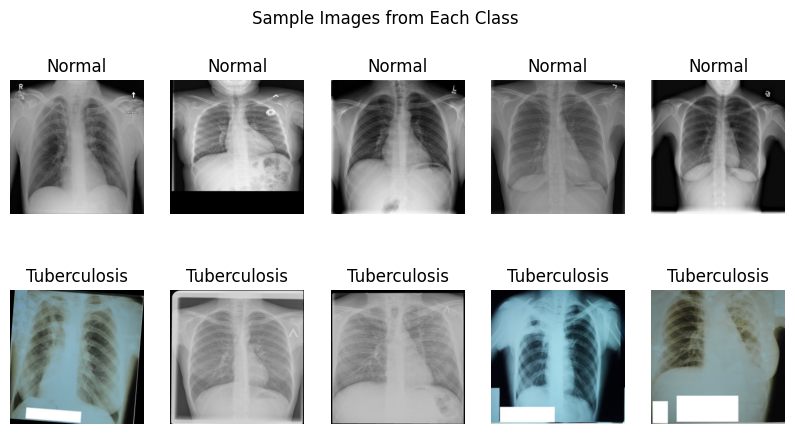

In [29]:
# Display sample images from each class
plt.figure(figsize=(10, 5))
for i in range(5):
    # Display Normal images
    plt.subplot(2, 5, i+1)
    plt.imshow(normal_images[random.randint(0, len(normal_images) - 1)])
    plt.title("Normal")
    plt.axis("off")

    # Display Tuberculosis images
    plt.subplot(2, 5, i+6)
    plt.imshow(tuberculosis_images[random.randint(0, len(tuberculosis_images) - 1)])
    plt.title("Tuberculosis")
    plt.axis("off")

plt.suptitle("Sample Images from Each Class")
plt.show()

# ALEXNET

In [70]:
import os
import numpy as np
import random
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import VGG16  # Transfer Learning Example


In [72]:
# AlexNet Model
def create_alexnet_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = layers.Conv2D(256, (5, 5), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(1, activation='sigmoid')(x)  # Binary classification
    return Model(inputs=inputs, outputs=output)

# Compile and train
alexnet_model = create_alexnet_model()

alexnet_model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,286,849 (222.35 MB)

 Trainable params: 58,286,145 (222.34 MB)

 Non-trainable params: 704 (2.75 KB)

In [105]:
alexnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

history = alexnet_model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=12,
    validation_data=(val_images, val_labels)
)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12


68/68 ━━━━━━━━━━━━━━━━━━━━ 58s 823ms/step - accuracy: 0.8556 - loss: 0.4291 - val_accuracy: 0.8500 - val_loss: 0.3198
Epoch 2/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 55s 803ms/step - accuracy: 0.9201 - loss: 0.2528 - val_accuracy: 0.7417 - val_loss: 2.2665
Epoch 3/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 55s 803ms/step - accuracy: 0.9286 - loss: 0.2107 - val_accuracy: 0.8792 - val_loss: 0.3522
Epoch 4/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 57s 840ms/step - accuracy: 0.9205 - loss: 0.2196 - val_accuracy: 0.8417 - val_loss: 0.4194
Epoch 5/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 58s 848ms/step - accuracy: 0.9007 - loss: 0.3052 - val_accuracy: 0.7167 - val_loss: 0.6215
Epoch 6/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 781ms/step - accuracy: 0.8044 - loss: 0.5264 - val_accuracy: 0.5000 - val_loss: 0.9914
Epoch 7/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 773ms/step - accuracy: 0.8907 - loss: 0.3871 - val_accuracy: 0.5000 - val_loss: 1.3242
Epoch 8/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 766ms/step - accuracy: 0.8905 - loss: 0.4397 - val_accuracy: 0.895

In [35]:
alexnet_model.save('alexnet_model.h5')

In [33]:
from tensorflow.keras.models import load_model

# Replace 'your_model.h5' with the path to your .h5 model file
alexnet_model = load_model('alexnet_model.h5')


In [106]:
test_loss, test_acc = alexnet_model.evaluate(test_images,test_labels, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 91.83%


In [107]:
test_loss, test_accuracy = alexnet_model.evaluate(test_images, test_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9125 - loss: 0.3107
Test Loss: 0.25664010643959045
Test Accuracy: 0.9183333516120911


In [108]:
y_pred_probs = alexnet_model.predict(test_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (test_labels > 0.5).astype(int)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


In [110]:
from sklearn.metrics import classification_report, confusion_matrix
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       300
           1       0.88      0.97      0.92       300

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600

Confusion Matrix:
[[259  41]
 [  8 292]]


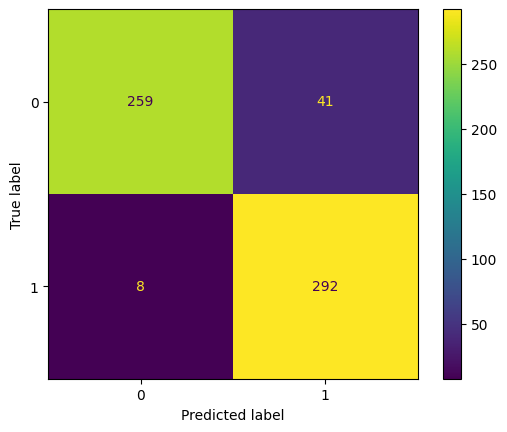

In [111]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(test_labels_binary, y_pred_binary)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [112]:
predictions = alexnet_model.predict(test_images)

# Print the shape of the predictions array
print("Shape of predictions array:", predictions.shape)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step
Shape of predictions array: (600, 1)


In [25]:
import tensorflow.keras as K
last_conv_layer = next(x for x in alexnet_model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'conv2d_4'

In [26]:
spatial_maps =  alexnet_model.get_layer('conv2d_1').output
print(spatial_maps)

<KerasTensor shape=(None, 30, 30, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_4>


In [27]:
# get the output of the model
output_with_batch_dim = alexnet_model.output
print(f"Model output includes batch dimension, has shape {output_with_batch_dim.shape}")
print(f"excluding the batch dimension, the output for all 14 categories of disease has shape {output_with_batch_dim[0].shape}")

Model output includes batch dimension, has shape (None, 1)
excluding the batch dimension, the output for all 14 categories of disease has shape (1,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1293']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


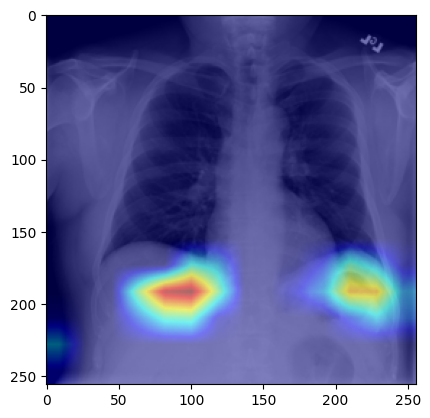

In [119]:
#Preprocess the test image
test_img = test_images[168]

# Preprocessed image into GradCAM
GradCAM(alexnet_model, test_img, plot_results=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

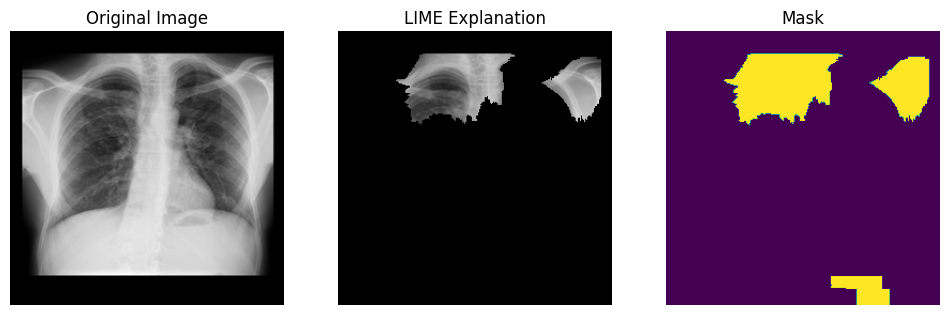

In [114]:
# Define a function to predict probabilities using the model
predict_fn = lambda x: alexnet_model.predict(x)

explainer = lime_image.LimeImageExplainer()

# Select a sample image from the test set
sample_index = 155  # Index of the sample image in the test set
sample_image = test_images[sample_index]
sample_label = test_labels[sample_index]

# Explain the model's prediction for the sample image
explanation = explainer.explain_instance(sample_image, predict_fn, hide_color=0, num_samples=1000)

# Get the explanation image and mask
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# Plot the original image, masked image, and the mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image)
plt.title("LIME Explanation")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title("Mask")
plt.axis('off')

plt.show()

In [33]:
# Print text explanation
print(explanation.local_exp[explanation.top_labels[0]])

[(6, 0.014735540846132064), (27, -0.010240175409325335), (0, 0.009526245831269974), (9, 0.0023812112060504057), (26, -0.0022769255675992245), (2, 0.0021825395076597942), (32, 0.0019683897924582085), (12, -0.0018989102435834028), (20, 0.0018576424561600065), (22, 0.0018045629387833278), (25, 0.001730558518555906), (18, 0.0015671539332307376), (4, 0.0014466212070953315), (5, -0.001378893528850733), (34, 0.0013759161980050098), (19, 0.001098343143681779), (24, -0.0009914153320820323), (15, -0.0008175472713694553), (7, 0.0007389742291059737), (21, -0.0006412091629364081), (10, -0.0006258435466654993), (3, -0.000612951475415316), (28, -0.0005703862144232949), (1, 0.0005700182524048674), (16, 0.0005128383734933243), (31, 0.0003299477223339102), (8, 0.0003178853447048231), (30, 0.0002290665035987611), (14, 0.00022706317324810776), (29, 0.00013714179844003497), (11, -0.00012531224635466018), (33, 0.00012081502569745798), (23, -9.866877741503516e-05), (17, -7.585522929653044e-05), (13, 5.972766

# WideResNet

In [76]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image

In [77]:
# ✅ Define WideResNet_Model
def create_wideresnet_model(input_shape=(256, 256, 3)):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # 🔓 Unfreeze last 30 layers for fine-tuning
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [78]:
# ✅ Build and compile the model
WideResNet_Model = create_wideresnet_model()
WideResNet_Model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

WideResNet_Model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 14,712,577 (56.12 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [80]:
history = WideResNet_Model.fit(
    train_images,train_labels,
    epochs=12,
    validation_data=(val_images, val_labels),
)

Epoch 1/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7087 - loss: 0.5498 - val_accuracy: 0.4167 - val_loss: 0.6943
Epoch 2/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9066 - loss: 0.2526 - val_accuracy: 0.5000 - val_loss: 0.8176
Epoch 3/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9507 - loss: 0.1572 - val_accuracy: 0.5000 - val_loss: 1.0172
Epoch 4/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9655 - loss: 0.1019 - val_accuracy: 0.7500 - val_loss: 0.4645
Epoch 5/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9657 - loss: 0.1036 - val_accuracy: 0.7417 - val_loss: 0.5138
Epoch 6/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9887 - loss: 0.0485 - val_accuracy: 0.9583 - val_loss: 0.1328
Epoch 7/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9858 - loss: 0.0499 - val_accuracy: 0.7500 - val_loss: 0.6907
Epoch 8/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9837 - loss: 0.0510 - val_accuracy: 0.9625 - val_loss

In [67]:
WideResNet_Model.save('WideResNet_Model.h5')

In [8]:
from tensorflow.keras.models import load_model

# Replace 'your_model.h5' with the path to your .h5 model file
WideResNet_Model = load_model('WideResNet_Model.h5')


W0000 00:00:1745167411.789120    1975 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [81]:
test_loss, test_accuracy = WideResNet_Model.evaluate(test_images, test_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 832ms/step - accuracy: 0.9637 - loss: 0.0900
Test Loss: 0.07333698868751526
Test Accuracy: 0.9683333039283752


In [82]:
y_pred_probs = WideResNet_Model.predict(test_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (test_labels > 0.5).astype(int)

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 914ms/step


In [83]:
from sklearn.metrics import classification_report, confusion_matrix

# Then run this:
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       300
           1       0.99      0.95      0.97       300

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Confusion Matrix:
[[296   4]
 [ 15 285]]


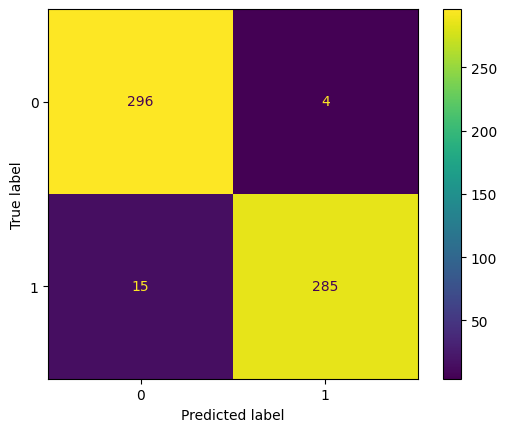

In [84]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(test_labels_binary, y_pred_binary)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [85]:
predictions = WideResNet_Model.predict(test_images)

# Print the shape of the predictions array
print("Shape of predictions array:", predictions.shape)

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 835ms/step
Shape of predictions array: (600, 1)


In [86]:
import tensorflow.keras as K
last_conv_layer = next(x for x in WideResNet_Model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'conv5_block3_3_conv'

In [87]:
spatial_maps =  WideResNet_Model.get_layer('conv5_block3_3_conv').output
print(spatial_maps)

<KerasTensor shape=(None, 8, 8, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1481>


In [103]:
# get the output of the model
output_with_batch_dim = WideResNet_Model.output
print(f"Model output includes batch dimension, has shape {output_with_batch_dim.shape}")
print(f"excluding the batch dimension, the output for all 14 categories of disease has shape {output_with_batch_dim[0].shape}")

Model output includes batch dimension, has shape (None, 1)
excluding the batch dimension, the output for all 14 categories of disease has shape (1,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1310']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


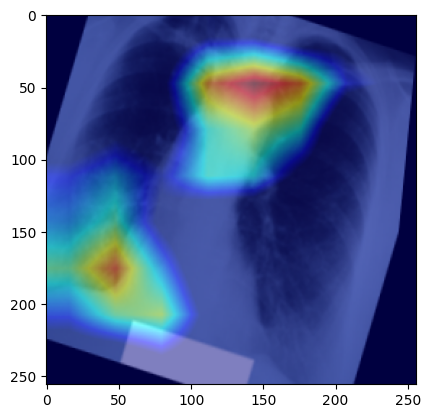

In [88]:
#Preprocess the test image
test_img = test_images[163]

# Preprocessed image into GradCAM
GradCAM(WideResNet_Model, test_img, plot_results=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

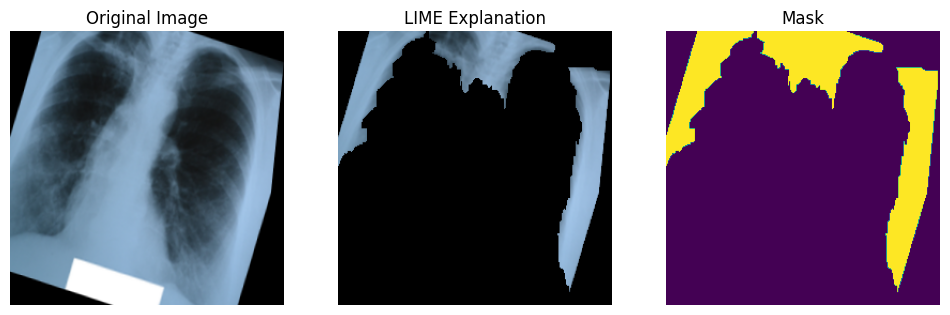

In [120]:
# Define a function to predict probabilities using the model
predict_fn = lambda x: WideResNet_Model.predict(x)

explainer = lime_image.LimeImageExplainer()

# Select a sample image from the test set
sample_index = 163  # Index of the sample image in the test set
sample_image = test_images[sample_index]
sample_label = test_labels[sample_index]

# Explain the model's prediction for the sample image
explanation = explainer.explain_instance(sample_image, predict_fn, hide_color=0, num_samples=1000)

# Get the explanation image and mask
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# Plot the original image, masked image, and the mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image)
plt.title("LIME Explanation")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title("Mask")
plt.axis('off')

plt.show()

In [101]:
# Print text explanation
print(explanation.local_exp[explanation.top_labels[0]])

[(33, -0.006585761256926581), (32, -0.00570567287961063), (56, -0.005594454329716526), (47, -0.0045525768786302025), (55, -0.00379448632172498), (81, 0.0032706614085140913), (23, 0.003212556337550817), (48, -0.002965158691705455), (2, 0.0029382816849971055), (72, -0.002729307185977217), (14, 0.002727098611918649), (15, 0.002594874132391668), (27, -0.002443539533127214), (41, 0.002370413562810526), (62, -0.002320223023078953), (66, -0.00221897979793718), (0, 0.0020393726913690968), (24, -0.0019140246609916395), (79, -0.0019076807463050116), (31, -0.00190452480379039), (59, 0.0018150505082451221), (78, -0.0018114686379307385), (49, -0.0017425220345801773), (20, 0.0017070359542160204), (92, 0.0016744847532875965), (35, -0.0016537950770967595), (73, 0.0015796717439205549), (21, 0.0015311965229887156), (12, -0.0015237003255726958), (93, -0.0014808080799309804), (91, 0.0014781709451607773), (97, -0.0013936205289875), (52, -0.0013752104959567498), (90, -0.0013576995807872178), (104, 0.0012941

# LENET

In [90]:
def create_lenet_model(input_shape, num_classes=1):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(6, (5, 5), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dense(84, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Output layer

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
input_shape = (256, 256, 3)  # Example input shape
num_classes = 1  # Example number of classes for binary classification
lenet_model = create_lenet_model(input_shape, num_classes)

# Print model summary
lenet_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 252, 252, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 126, 126, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 122, 122, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 120)            │     7,144,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,157,561 (27.30 MB)

 Trainable params: 7,157,561 (27.30 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# input_shape = (256, 256, 3)
# lenet_model = create_lenet_model(input_shape)

# Compile the model
lenet_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
# Print model summary
# lenet_model.summary()

In [92]:
history = lenet_model.fit(train_images, train_labels,
                          epochs=12,
                          batch_size=32,
                          validation_data=(val_images, val_labels))

Epoch 1/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - accuracy: 0.6523 - loss: 1.7722 - val_accuracy: 0.9583 - val_loss: 0.1878
Epoch 2/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - accuracy: 0.9181 - loss: 0.1994 - val_accuracy: 0.8167 - val_loss: 0.3962
Epoch 3/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.9240 - loss: 0.1927 - val_accuracy: 0.9542 - val_loss: 0.1450
Epoch 4/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.9555 - loss: 0.1047 - val_accuracy: 0.9583 - val_loss: 0.1530
Epoch 5/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.9705 - loss: 0.0752 - val_accuracy: 0.9625 - val_loss: 0.1189
Epoch 6/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - accuracy: 0.9816 - loss: 0.0580 - val_accuracy: 0.9708 - val_loss: 0.1116
Epoch 7/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.9833 - loss: 0.0430 - val_accuracy: 0.9708 - val_loss: 0.1295
Epoch 8/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 293ms/step - accuracy: 0.9891 - loss: 0.0427 - val_accu

In [93]:

test_loss, test_accuracy = lenet_model.evaluate(test_images, test_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9729 - loss: 0.1403
Test Loss: 0.12223805487155914
Test Accuracy: 0.9750000238418579


In [94]:
y_pred_probs = lenet_model.predict(test_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (test_labels > 0.5).astype(int)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [96]:
from sklearn.metrics import classification_report, confusion_matrix
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       300
           1       0.96      0.99      0.98       300

    accuracy                           0.97       600
   macro avg       0.98      0.98      0.97       600
weighted avg       0.98      0.97      0.97       600

Confusion Matrix:
[[289  11]
 [  4 296]]


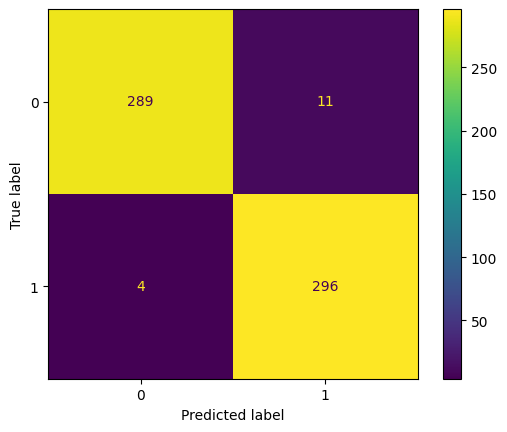

In [97]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(test_labels_binary, y_pred_binary)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [28]:
predictions = lenet_model.predict(test_images)

# Print the shape of the predictions array
print("Shape of predictions array:", predictions.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Shape of predictions array: (340, 1)


In [29]:
import tensorflow.keras as K
last_conv_layer = next(x for x in lenet_model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'conv2d_1'

In [30]:
spatial_maps =  lenet_model.get_layer('conv2d_1').output
print(spatial_maps)

<KerasTensor shape=(None, 122, 122, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>


In [31]:
# get the output of the model
output_with_batch_dim = lenet_model.output
print(f"Model output includes batch dimension, has shape {output_with_batch_dim.shape}")
print(f"excluding the batch dimension, the output for all 14 categories of disease has shape {output_with_batch_dim[0].shape}")

Model output includes batch dimension, has shape (None, 1)
excluding the batch dimension, the output for all 14 categories of disease has shape (1,)


In [98]:
def GradCAM(model, image, interpolant=0.5, plot_results=True):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    # Preprocess image and make prediction using our model
    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)

    # Predict
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    # Find the last convolutional layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break

    if last_conv_layer is None:
        raise ValueError("No convolutional layer found in the model.")

    # Create a model to extract feature maps and predictions
    gradient_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    # Compute gradient of top predicted class
    with tf.GradientTape() as tape:
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)

    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    if plot_results:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

In [30]:
def preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")
            image = image.resize((256, 256))
            image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label)
    return images, labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1490']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


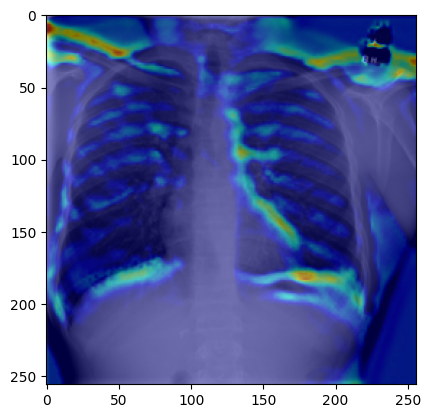

In [101]:
#Preprocess the test image
test_img = test_images[158]

# Preprocessed image into GradCAM
GradCAM(lenet_model, test_img, plot_results=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

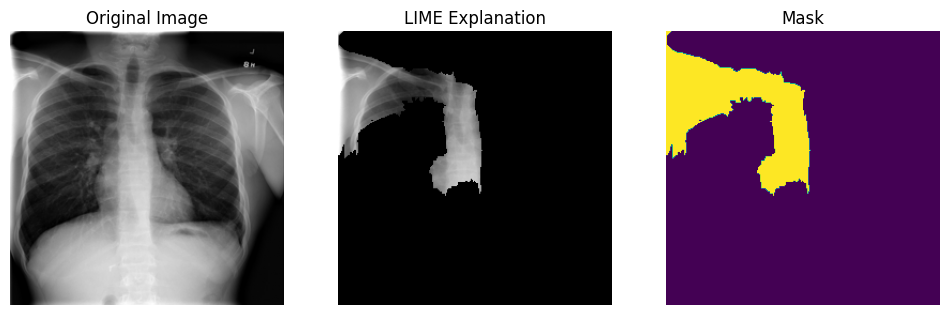

In [102]:
# Define a function to predict probabilities using the model
predict_fn = lambda x: lenet_model.predict(x)

explainer = lime_image.LimeImageExplainer()

# Select a sample image from the test set
sample_index = 158  # Index of the sample image in the test set
sample_image = test_images[sample_index]
sample_label = test_labels[sample_index]

# Explain the model's prediction for the sample image
explanation = explainer.explain_instance(sample_image, predict_fn, hide_color=0, num_samples=1000)

# Get the explanation image and mask
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# Plot the original image, masked image, and the mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image)
plt.title("LIME Explanation")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title("Mask")
plt.axis('off')

plt.show()

In [37]:
# Print text explanation
print(explanation.local_exp[explanation.top_labels[0]])

[(37, -0.29881376929763825), (6, 0.134318323097355), (35, 0.09193715851427783), (15, -0.08955381992662031), (43, -0.07870863955247424), (4, -0.07801633767245787), (41, 0.06584649036049768), (11, -0.06255087507502308), (26, -0.06189113917661924), (19, -0.06027976648590247), (17, -0.055787500227226214), (12, -0.04940674751086696), (40, -0.04875209584168659), (3, 0.04645830389366495), (39, 0.046198217370969956), (34, -0.035950756085047116), (33, -0.03594745064255816), (38, -0.027839127812538222), (31, -0.026534899564734232), (16, 0.026093618441441258), (5, -0.025887219503332858), (22, 0.022185486510156494), (25, -0.022060179725075665), (32, -0.0217567063864224), (28, 0.02126112704938048), (8, -0.02098410966805423), (7, -0.020120381033694713), (1, -0.018997691346841098), (2, -0.018353984548195073), (18, 0.01484498443004903), (20, -0.013500016428771636), (23, -0.012658080837112364), (14, -0.011509931129539432), (36, -0.010793306000745004), (29, 0.010134013848267568), (9, 0.00988043356996466

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras import layers


In [43]:
def create_densenet_model(input_shape=(256, 256, 3), num_classes=1):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)

    # Fine-tune last few layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [45]:
from tensorflow.keras.optimizers import Adam
densenet_model = create_densenet_model()
densenet_model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

Train images shape: (2160, 256, 256, 3)
Train labels shape: (2160,)


In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

densenet_model.fit(train_images, train_labels, 
          epochs=30, 
          batch_size=32, 
          validation_data=(val_images, val_labels), 
          callbacks=callbacks)


Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9681 - loss: 0.1062 - val_accuracy: 0.9875 - val_loss: 0.0624 - learning_rate: 1.0000e-05
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9720 - loss: 0.0987 - val_accuracy: 0.9875 - val_loss: 0.0570 - learning_rate: 1.0000e-05
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9788 - loss: 0.0901 - val_accuracy: 0.9875 - val_loss: 0.0528 - learning_rate: 1.0000e-05
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9803 - loss: 0.0869 - val_accuracy: 0.9875 - val_loss: 0.0497 - learning_rate: 1.0000e-05
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9804 - loss: 0.0807 - val_accuracy: 0.9875 - val_loss: 0.0472 - learning_rate: 1.0000e-05
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9866 - loss: 0.0675 - val_accuracy: 0.9875 - val_loss: 0.0445 - learning_rate: 1.0000e-05
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9838 - loss:

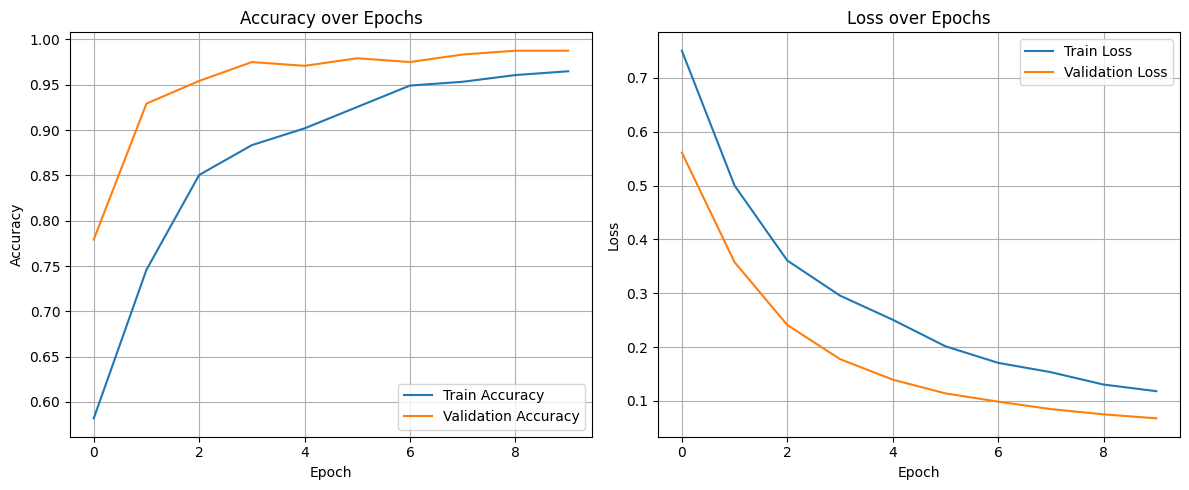

In [58]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [59]:
test_loss, test_accuracy = densenet_model.evaluate(test_images, test_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9927 - loss: 0.0321
Test Loss: 0.022184889763593674
Test Accuracy: 0.9950000047683716


In [60]:
def GradCAM(model, image, interpolant=0.5, plot_results=True):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    # Preprocess image and make prediction using our model
    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)

    # Predict
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    # Find the last convolutional layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break

    if last_conv_layer is None:
        raise ValueError("No convolutional layer found in the model.")

    # Create a model to extract feature maps and predictions
    gradient_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    # Compute gradient of top predicted class
    with tf.GradientTape() as tape:
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)

    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    if plot_results:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


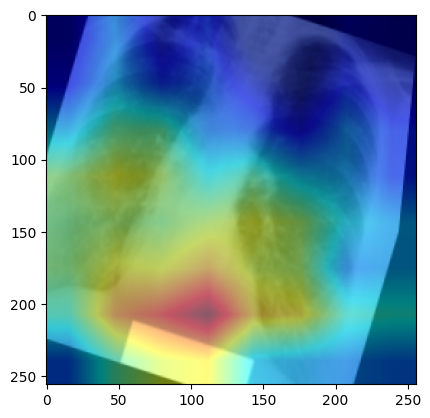

In [65]:
GradCAM(densenet_model,test_images[163])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

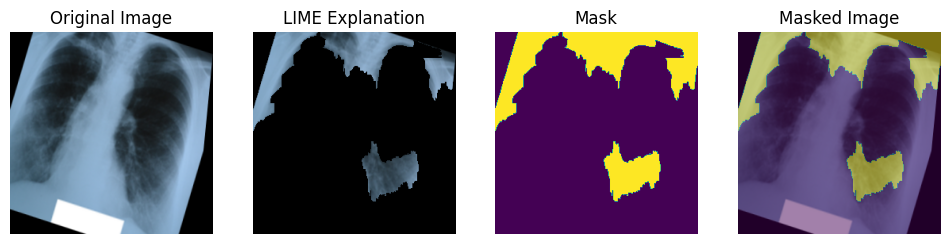

In [66]:
# Define a function to predict probabilities using the model
predict_fn = lambda x: densenet_model.predict(x)

explainer = lime_image.LimeImageExplainer()

# Select a sample image from the test set
sample_index = 163  # Index of the sample image in the test set
sample_image = test_images[sample_index]
sample_label = test_labels[sample_index]

# Explain the model's prediction for the sample image
explanation = explainer.explain_instance(sample_image, predict_fn, hide_color=0, num_samples=1000)

# Get the explanation image and mask
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# Plot the original image, masked image, and the mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(image)
plt.title("LIME Explanation")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(mask)
plt.title("Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(sample_image)
plt.imshow(mask, alpha=0.5)
plt.title("Masked Image")
plt.axis('off')

plt.show()

In [67]:
y_pred_probs = densenet_model.predict(np.array(test_images))

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (test_labels > 0.5).astype(int)

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


In [68]:
from sklearn.metrics import confusion_matrix

classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)
# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       0.99      1.00      1.00       300

    accuracy                           0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600

Confusion Matrix:
[[298   2]
 [  1 299]]


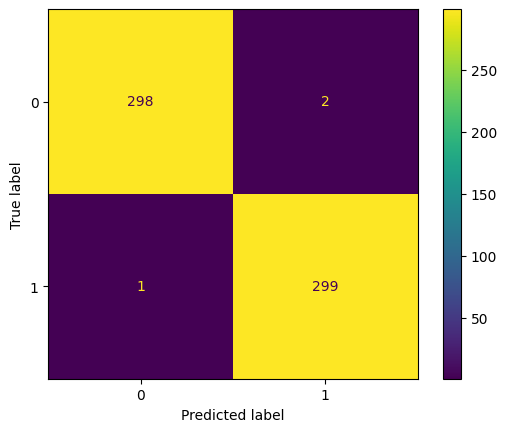

In [69]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(test_labels_binary, y_pred_binary)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()